In [1]:
!pip install h3

In [2]:
!pip install networkx

In [8]:
import pandas as pd
import networkx as nx
import h3
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import transform

# Wczytanie danych o czasie przejazdu między heksami
new_df = pd.read_csv('h3_routing_dict.csv')

# Tworzenie grafu na podstawie danych z pliku CSV
G = nx.Graph()

# Dodawanie krawędzi między heksami z czasem przejazdu jako wagą
for _, row in new_df.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['time'])

# Funkcja do wyznaczania obszaru serwisowego
def get_trade_area_networkx(hex_cell, budget):
    # Algorytm Dijkstra ograniczony budżetem czasowym
    lengths = nx.single_source_dijkstra_path_length(G, hex_cell, cutoff=budget, weight='weight')
    list_trade_areas = {cell for cell, time in lengths.items() if time <= budget}
    return list_trade_areas

# Ustalenie heksu początkowego
h3_start = h3.geo_to_h3(50.095, 19.9075, 8)

# Wyznaczanie obszaru serwisowego
trade_area_hexes = get_trade_area_networkx(h3_start, 1200)



<AxesSubplot:>

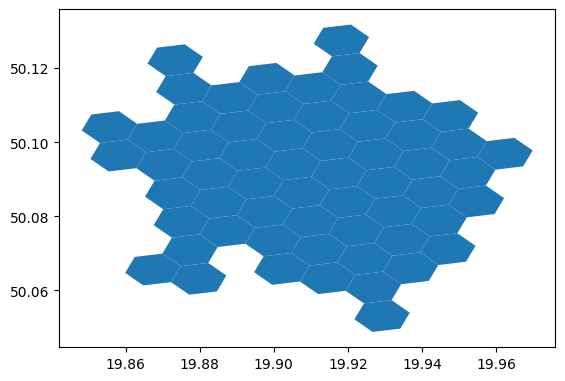

In [10]:
# Konwersja obszaru serwisowego na geometrię w GeoDataFrame
list_heks = []
for heks in trade_area_hexes:
    heks_geom = h3.h3_to_geo_boundary(heks, geo_json=True)
    gdf = gpd.GeoDataFrame(geometry=[Polygon(heks_geom)])
    list_heks.append(gdf)

# Połączenie wszystkich heksów w jeden GeoDataFrame i zmiana współrzędnych
gdf_ta = pd.concat(list_heks, ignore_index=True)
gdf_ta['geometry'] = gdf_ta['geometry'].map(lambda polygon: transform(lambda x, y: (x, y), polygon))

# Wyświetlenie wyniku
gdf_ta.plot()
